In [1]:
import fitsio
import numpy as np

In [2]:
import proplot as pplt

In [3]:
d = fitsio.read("tnames.fits")

In [4]:
from ngmix.medsreaders import NGMixMEDS

In [5]:
m = NGMixMEDS("./meds/DES0021-5414_r4907p01_r_meds-Y6A1.fits.fz")

In [36]:
ii = m.get_image_info()

In [45]:
ii.dtype.names

('image_path',
 'image_ext',
 'weight_path',
 'weight_ext',
 'seg_path',
 'seg_ext',
 'bmask_path',
 'bmask_ext',
 'bkg_path',
 'bkg_ext',
 'image_id',
 'image_flags',
 'magzp',
 'scale',
 'position_offset',
 'wcs')

In [42]:
import os

def get_ccdnum(fname):
    return int(os.path.basename(fname).split("_")[2][1:])

In [85]:
import tqdm

from ngmix.prepsfmom import PGaussMom
vals = []
fitter = PGaussMom(1.75)

with tqdm.tqdm(range(m.size), ncols=79) as mitr:
    for i in mitr:
        for j in range(m["ncutout"][i]):
            if j > 0:
                try:
                    o = m.get_obs(i, j, weight_type="uberseg")
                except Exception:
                    o = None

                if o is not None and np.all(o.weight > 0) and np.all(o.bmask == 0):
                    res = fitter.go(o)
                    if (
                        res["flags"] == 0 
                        and res["s2n"] > 7 
                        and res["s2n"] < 100
                        and res["T"] > 0.2
                        and res["T"] < 1
                    ):
                        ccdnum = get_ccdnum(ii["image_path"][m["file_id"][i, j]])
                        if ccdnum >= 32:
                            rr = 4096 - m["orig_row"][i, j]
                        else:
                            rr = m["orig_row"][i, j]
                        vals.append((m["id"][i], ccdnum, res["e"][0], rr))
                        mitr.set_description("% 5d objects" % len(vals))

  927 objects:  10%|█▉                  | 6490/65377 [07:52<1:11:26, 13.74it/s]


KeyboardInterrupt: 

In [93]:
d = np.array(vals, dtype=[("id", "i8"), ("ccdnum", "i4"), ("e1", "f8"), ("row", "f8")])

slope S/N: 0.7822911893630142


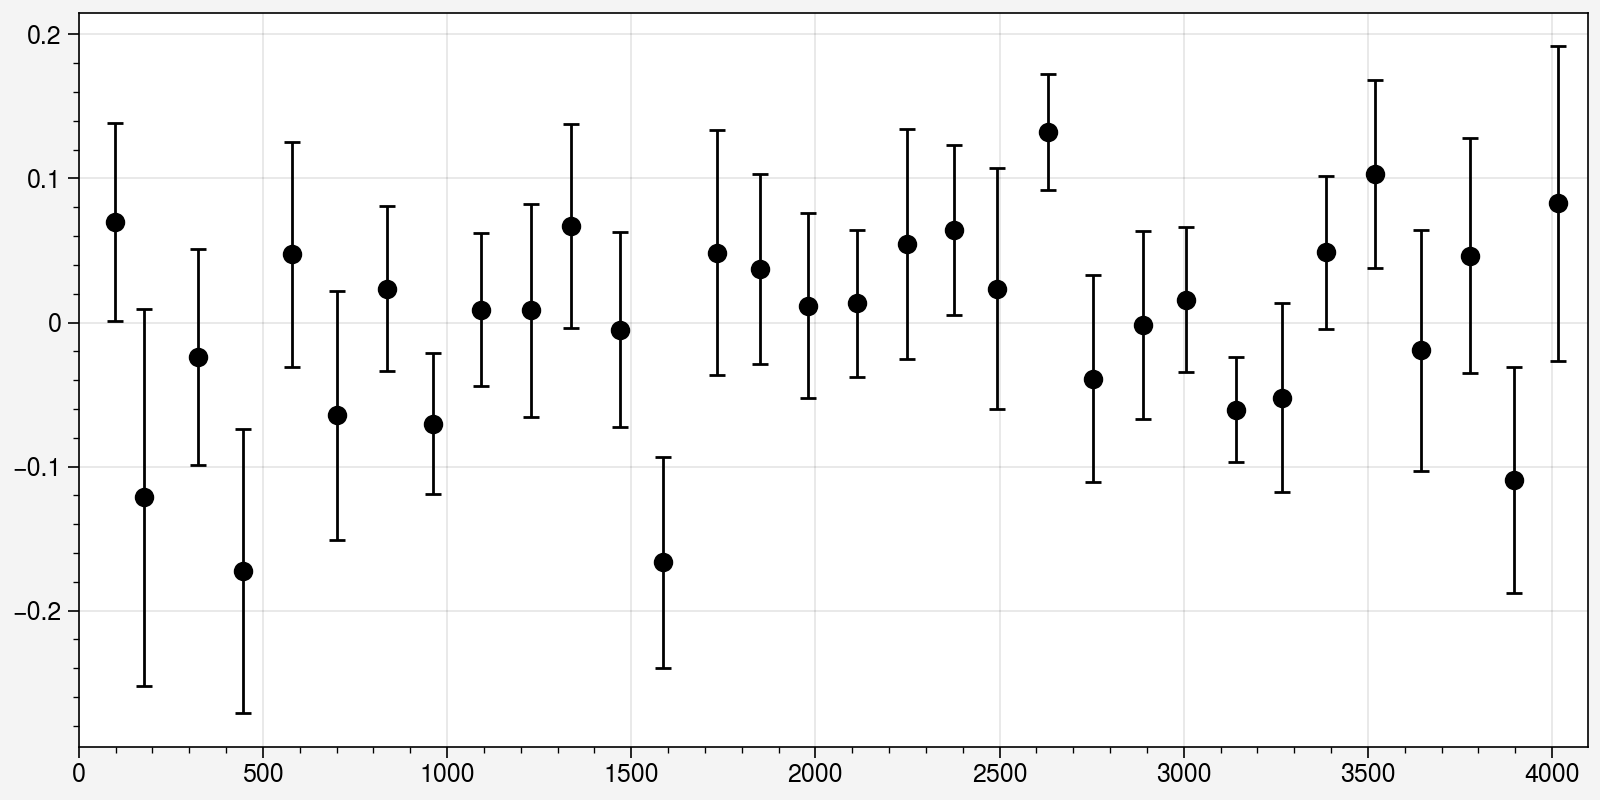

In [95]:
from esutil.stat import Binner

b = Binner(d["row"], d["e1"])
b.dohist(binsize=128, min=1, max=4096)
b.calc_stats()

fig, axs = pplt.subplots(figsize=(8, 4))
axs.plot(b["xmean"], b["ymean"], "ko", bardata=b["yerr"])
axs.set_xlim(0, 4096)

from scipy.optimize import curve_fit

def lin(x, m, c):
    return x*m + c
    
r = curve_fit(lin, b["xmean"], b["ymean"], sigma=b["yerr"], absolute_sigma=True)

print("slope S/N:", r[0][0]/np.sqrt(r[1][0, 0]))